# Parallelization!

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

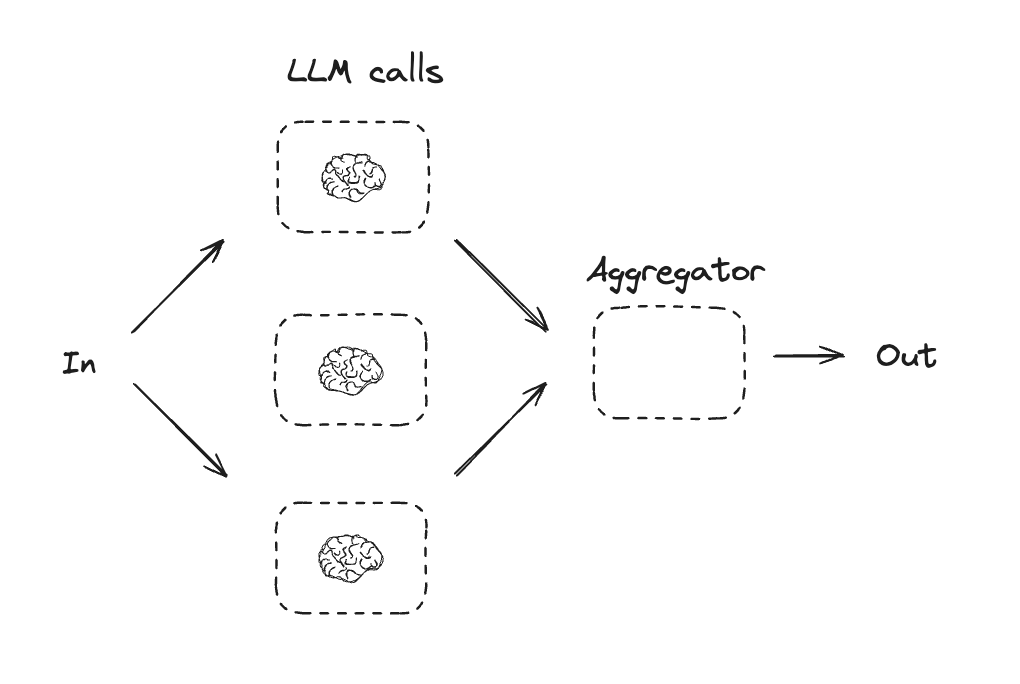

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [3]:
from langchain_openai import ChatOpenAI
import os

# build your agent
llm = ChatOpenAI(
    model="gpt-4o-mini",            # Use a lightweight GPT-4 model
    temperature=0,                  # Deterministic output (no randomness)
    api_key=os.environ["OPEN_AI_SECRET_KEY"]  # Pull your OpenAI key from environment
)

In [5]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [6]:
# Nodes
# as you can see the returns write to the state!
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

In [7]:
def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

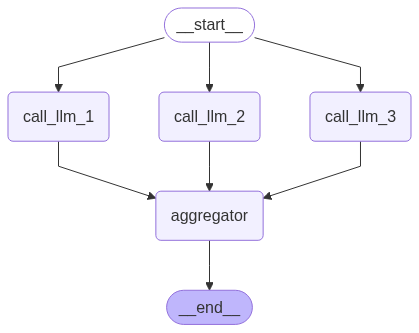

In [8]:
# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [9]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
Once upon a time in a quaint little village nestled between rolling hills and lush forests, there was a peculiar phenomenon: every cat in the village had a secret. By day, they lounged in sunbeams, chased butterflies, and napped in cozy corners. But by night, when the moon hung high and the stars twinkled like diamonds, they transformed into something extraordinary.

In this village lived a young girl named Lila, who adored cats more than anything else in the world. She had a fluffy orange tabby named Marmalade, a sleek black cat named Shadow, and a regal Siamese named Luna. Lila often wondered what her feline friends did when the sun set and the world fell asleep. Little did she know, they were part of a magical society known as the Night Paws.

One evening, as the sun dipped below the horizon, Lila noticed something unusual. Marmalade, Shadow, and Luna were gathered at the edge of the garden, their eyes gleaming with excitement. Curi